In [18]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18, z_at_value
from astropy.constants import c
from scipy.ndimage.filters import gaussian_filter
import astropy.units as u
import hankl
from scipy import interpolate
from scipy.integrate import quadrature
from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from sympy.physics.wigner import wigner_3j
from scipy.integrate import quadrature
import sys
sys.path.append('/global/u1/a/ab2368/varying_dndzs/Varying_dndzs/biases_code/')
import biases
import os
# Hack to get Latex working on Perlmutter. Due to Joe de Rose
os.environ['PATH'] = '/global/common/sw/cray/sles15/x86_64/texlive/live/gcc/8.2.0/tiozj27/bin/x86_64-linux/:{}'.format(os.environ['PATH'])

plt.style.use('/global/u1/a/ab2368/plt_styles/JCAP_paper.mplstyle')
plots_dir = '/global/u1/a/ab2368/varying_dndzs/Varying_dndzs/paper/63ffea69c50c290da6f23d0e/plots/'

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_57989/1816115311.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate $C_l^{\Delta \phi \Delta \phi}(k_1,k_2)$ (for insight)

Note that we don't actually need this quantity to evaluate the biases, we just do it for insight

Note that the sampling in r requires care for FFTLog to converge

In [19]:
sigma = 0.06 # Standard deviation of the fiducial dndz
z_mean = 0.59 # Central redshift of the fiducial dndz

# Set the range for the integrals over r. If this changes, the normalization of phi(r) will need to be changed too
z_min_int = 0.005
z_max_int = z_mean+2

# Now characterize the perturbations to the dndz
sigma_zshift = 0.006 # Standard deviation of the shifts in the central redshift of the distribution
sigma_zwidth = 0 # Standard deviation of the variations in the width of the distribution

# Smoothing of the anisotropy. You'll most likely want to set this to 0
smoothing_factor = 0

nside = 128
# We will up-sample the maps
nside_out = 128 # If running on a laptop, don't go above nside_out=128 (nside_out = 256 already requires 20Gb of memory)

# Initialize samples in r (r is comoviing distance throughout)
n_samples_of_r = 2**10 # Choose a power of 2

# Properties of the projection anisotropy spectrum
alpha = -2 # Spectral index of the anisotropy spectrum
lmax_pert = 100 # Scale at which we truncate the projection anisotropy

# Title of the object to be loaded from file. Default is 'general'
title = 'general'

In [20]:
# Load the z_shifts array from file
filename = '/pscratch/sd/a/ab2368/data/{}_alpha{}_lmaxpert{}_sigmazshift{}_nside{}_sigma{}'.format(title, alpha, lmax_pert, sigma_zshift, nside, sigma)
loaded_exp = biases.load_from_file(filename)
zmean_shifts_array = loaded_exp.zmean_shifts_array

# For now, let's say there are no variations to the width
width_shifts_array = np.zeros_like(zmean_shifts_array)

#Alternatively, uncomment the following to get white noise on the scale of nside
'''
modulation_of_mean_of_draws = 0 #modulating_map # Consider also modulating the mean of these shifts across the sky

# Draw random values in each pixel for the shift of the central redshift of the dndz
zmean_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_zshift, size=npix)
width_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_zwidth, size=npix)

'''

'\nmodulation_of_mean_of_draws = 0 #modulating_map # Consider also modulating the mean of these shifts across the sky\n\n# Draw random values in each pixel for the shift of the central redshift of the dndz\nzmean_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_zshift, size=npix)\nwidth_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_zwidth, size=npix)\n\n'

/global/homes/a/ab2368/.conda/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 1.416013e-07
  warnings.warn(


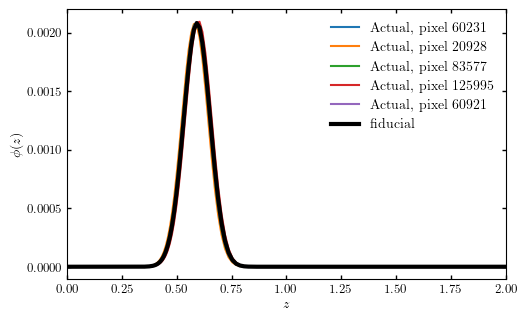

In [21]:
npix = hp.nside2npix(nside)
log_rmin = -4 # Choose integers here
log_rmax = 4 # Choose integers here
r_array = np.logspace(log_rmin,log_rmax,n_samples_of_r) 

# Get the redshift corresponding to these values of r in the Planck18 cosmology
z_array = np.zeros((npix, n_samples_of_r))
for i, chi in enumerate(r_array):
    z_array[:, i] = z_at_value(Planck18.comoving_distance, chi* u.Mpc) 

# In each pixel, calculate the perturbed dndz as a Gaussian in redshift
dndz_perturbed = (1/((sigma+width_shifts_array[..., np.newaxis])*np.sqrt(2*np.pi))) * np.exp(-(z_array - z_mean - zmean_shifts_array[..., np.newaxis])**2 /(2*(sigma+width_shifts_array[..., np.newaxis])**2))
# Take the fiducial dndz to be the monopole of the perturbed dndz
dndz_fid = np.mean(dndz_perturbed, axis=0)

# Convert dndz to selection function
phi_perturbed_array = (Planck18.H(z_array[0,:]) / c).value * dndz_perturbed
phi_fid_array = (Planck18.H(z_array[0,:]) / c).value * dndz_fid

# Normalize the selection function so that \int_{0}^{inf} dr phi(r) = 1
phi_norm, error = quadrature(interp1d(r_array, phi_fid_array), Planck18.comoving_distance(z_min_int).value, 
                                       Planck18.comoving_distance(z_max_int).value,
                                             tol=1e-20, maxiter=500)
phi_perturbed_array *= phi_norm**(-1)
phi_fid_array *= phi_norm**(-1)
phi_fid = interp1d(r_array, phi_fid_array)

# Extract the perturbation
delta_p_maps = phi_perturbed_array - phi_fid_array

# Plot some typical realizations
for pixel_id in np.random.randint(0,npix,5):
    plt.plot(z_array[0,:], phi_perturbed_array[pixel_id,:], label='Actual, pixel {}'.format(pixel_id))

# Plot the fiducial dndz
plt.plot(z_array[0,:], phi_fid_array, color='k', lw=3, label='fiducial')

plt.ylabel(r'$\phi(z)$')
plt.xlabel(r'$z$')
plt.xlim([0,2])
plt.legend()

delta_p_maps_upsampled = np.zeros((hp.nside2npix(nside_out), n_samples_of_r))
for i in range(len(r_array)):
    delta_p_maps_upsampled[:,i] = hp.ud_grade(delta_p_maps[:,i], nside_out)
    
delta_p_maps = delta_p_maps_upsampled

# To avoid ringing due to the hard edges on which we seed the anisotropy, consider smoothing the maps with a Gaussian 
sigma_gaussian_smoothing = smoothing_factor * np.sqrt(4*np.pi/npix) * (360*60/(2*np.pi)) # in arcmin

def bl(fwhm_arcmin, lmax):
    """ returns the map-level transfer function for a symmetric Gaussian beam.
         * fwhm_arcmin      = beam full-width-at-half-maximum (fwhm) in arcmin.
         * lmax             = maximum multipole.
    """
    ls = np.arange(0, lmax+1)
    return np.exp( -(fwhm_arcmin * np.pi/180./60.)**2 / (16.*np.log(2.)) * ls*(ls+1.) )

beam = bl(sigma_gaussian_smoothing, 3*nside_out-1)

# Take the spherical harmonic transform of each r slice. Conveniently, we can take complex SHT so array sizes reduce by x2
delta_p_lm_of_r = np.zeros((hp.Alm.getsize(3*nside_out-1), n_samples_of_r), dtype=complex)
for i in range(n_samples_of_r):
    delta_p_lm_of_r[:,i] = hp.map2alm(delta_p_maps[:,i])
    # Smooth the map to reduce ringing due to the hard edges of the big pixels
    delta_p_lm_of_r[:,i] = hp.almxfl(delta_p_lm_of_r[:,i], beam) 

In [22]:
# Next, we will want to take the (l+1/2)th order Hankel transform of each theta_alm
delta_p_lm_of_k = np.zeros_like(delta_p_lm_of_r) 
lmax = hp.Alm.getlmax(len(delta_p_lm_of_k))
Cl_deltap_of_k1_k2 = np.zeros((lmax+1, n_samples_of_r, n_samples_of_r))

for i in range(delta_p_lm_of_r.shape[0]):
    if i % 1000 == 0:
        # Print progress
        print('Completed {}%'.format(round(100*i/delta_p_lm_of_r.shape[0]), 3))
    l, m = hp.Alm.getlm(lmax, i) # Get the l corresponding to each value of m
    # Now get the Hankel transforms.
    # Importantly, after discussing with Minas, we use the Stirling approximation to the gamma functions in Eqn 16 
    # of https://jila.colorado.edu/~ajsh/FFTLog/fftlog.pdf, which diverges for mu>342
    k_array, delta_p_lm_of_k[i,:] = hankl.FFTLog(r_array, r_array*delta_p_lm_of_r[i,:], q=0, mu=l+0.5, ext=1, lowring=True, stirling_cutoff=-1)
    delta_p_lm_of_k[i,:] *= 1./k_array # Adapt to the convention in the Hankl code
    
    if m != 0:
        # Healpix indexes only m (not -m, since Ylm=Yl-m for a real field), so correct the sum for this
        factor = 2
    else:
        factor = 1
    # Get angular PS and deconvolve pixel window function for all possible combinations of k1 and k2 
    Cl_deltap_of_k1_k2[l,:,:] += factor * np.outer(delta_p_lm_of_k[i,:], np.conj(delta_p_lm_of_k[i,:])).real/ (2*l+1)

Completed 0%


/global/homes/a/ab2368/.conda/envs/varying_dndz/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


Completed 1%
Completed 3%
Completed 4%
Completed 5%
Completed 7%
Completed 8%
Completed 9%
Completed 11%
Completed 12%
Completed 14%
Completed 15%
Completed 16%
Completed 18%
Completed 19%
Completed 20%
Completed 22%
Completed 23%
Completed 24%
Completed 26%
Completed 27%
Completed 28%
Completed 30%
Completed 31%
Completed 32%
Completed 34%
Completed 35%
Completed 37%
Completed 38%
Completed 39%
Completed 41%
Completed 42%
Completed 43%
Completed 45%
Completed 46%
Completed 47%
Completed 49%
Completed 50%
Completed 51%
Completed 53%
Completed 54%
Completed 55%
Completed 57%
Completed 58%
Completed 60%
Completed 61%
Completed 62%
Completed 64%
Completed 65%
Completed 66%
Completed 68%
Completed 69%
Completed 70%
Completed 72%
Completed 73%
Completed 74%
Completed 76%
Completed 77%
Completed 78%
Completed 80%
Completed 81%
Completed 83%
Completed 84%
Completed 85%
Completed 87%
Completed 88%
Completed 89%
Completed 91%
Completed 92%
Completed 93%
Completed 95%
Completed 96%
Completed 97%

### Visualizing $C_l^{\Delta \phi \Delta \phi}(k)$

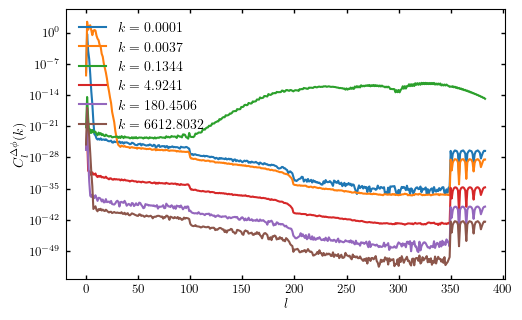

In [23]:
for k_idx, k in zip(np.arange(len(k_array))[::200], k_array[::200]):
    plt.semilogy(Cl_deltap_of_k1_k2[:,k_idx, k_idx], label=r'$k={}$'.format(round(k, 4)))
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l^{\Delta \phi}(k)$')
plt.legend()

There are large oscillations above l>350, probably due to the fact that we've had to use Stirling's approximation in FFTLog, but they happen many orders of magnitude below the dominant signal, at l's where we'll be truncating anyway, so they can probably be ignored.

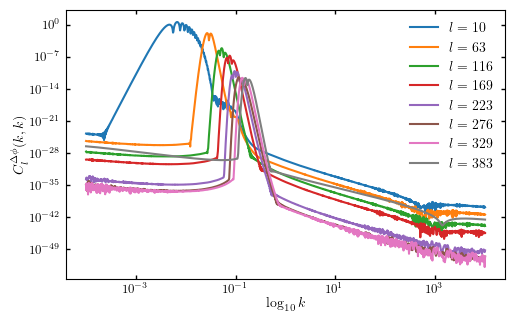

In [24]:
for l_to_plot in np.linspace(10,lmax,8, dtype=int):
    plt.loglog(k_array, np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2)[l_to_plot,:], label=r'$l={}$'.format(l_to_plot))
plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$C_l^{\Delta \phi}(k, k)$')
plt.legend()

In [25]:
X, Y = np.meshgrid(np.arange(len(k_array)), np.arange(lmax+1))
Z = np.log10(np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2))

/tmp/ipykernel_57989/1702883653.py:41: RuntimeWarning: invalid value encountered in log10
  Z_fixed_k = np.log10(Cl_deltap_of_k1_k2[:,:,k_idx])
/tmp/ipykernel_57989/1702883653.py:47: RuntimeWarning: invalid value encountered in log10
  Z_fixed_k = np.log10(-Cl_deltap_of_k1_k2[:,:,k_idx])


<Figure size 566.3x350 with 0 Axes>

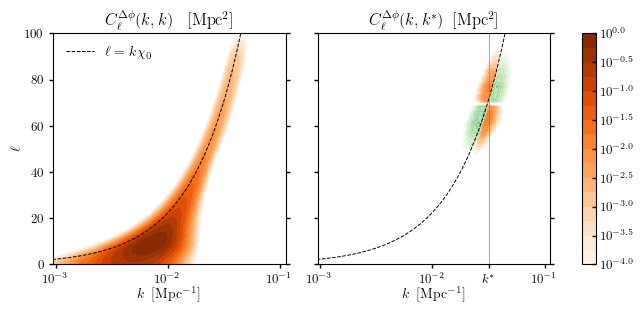

In [235]:
import matplotlib as mpl 

plt.clf()
fig, (ax, ax2, cax) = plt.subplots(ncols=3,figsize=(7,3), 
                  gridspec_kw={"width_ratios":[1, 1,0.06]})

#fig.subplots_adjust(wspace=0.5)
plt.axes(ax)

# Smooth array with a Gaussian filter for plotting purposes
Z_smoothed = gaussian_filter(Z, sigma=5)
im = plt.contourf(X, Y, Z_smoothed, levels=contours, cmap='Oranges', extend='neither')

ax.plot(k_array*Planck18.comoving_distance(z_mean).value, color='k', ls='--', lw=0.7, label=r'$\ell=k \chi_0$')

label_locs = np.arange(int(round(np.log10(np.min(k_array)),0)), int(round(np.log10(np.max(k_array)),0))+1, 1)
ax.set_xticks(np.linspace(0, len(k_array), len(label_locs)))
ax.set_xticklabels(np.array([r'$10^{'+str(x)+'}$' for x in label_locs]))

plt.title(r'$C_{\ell}^{\Delta \phi}(k, k)$ \, [Mpc$^2$]')
plt.xlabel(r'$k$\, [Mpc$^{-1}$]')

ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")
ax.xaxis.set_ticks_position('bottom')

ax.set_ylim([0,100])
ax.set_xlim([125,390])
plt.ylabel(r'$\ell$')
plt.legend()


plt.axes(ax2)



contours_offdiag = contours#contours#np.arange(-10,0,1)#np.arange(-3,1,0.5)

k_idx = np.where(np.log10(k_array)>-1.5)[0][0]

Z_fixed_k = np.log10(Cl_deltap_of_k1_k2[:,:,k_idx])
# Smooth array with a Gaussian filter for plotting purposes
Z_fixed_k_smoothed = gaussian_filter(Z_fixed_k, sigma=0)
Z_fixed_k_smoothed[np.isnan(Z_fixed_k)] = -100
plt.contourf(X, Y, Z_fixed_k_smoothed, levels=contours_offdiag, cmap='Oranges', extend='max', alpha=1)

Z_fixed_k = np.log10(-Cl_deltap_of_k1_k2[:,:,k_idx])
# Smooth array with a Gaussian filter for plotting purposes
Z_fixed_k_smoothed = gaussian_filter(Z_fixed_k, sigma=0)
Z_fixed_k_smoothed[np.isnan(Z_fixed_k)] = -100
plt.contourf(X, Y, Z_fixed_k_smoothed, levels=contours_offdiag, cmap='Greens', extend='max', alpha=0.5)


label_locs = np.arange(int(round(np.log10(np.min(k_array)),0)), int(round(np.log10(np.max(k_array)),0))+1, 1)
ax2.set_xticks(np.insert(np.linspace(0, len(k_array), len(label_locs)), 0, k_idx))
ax2.set_xticklabels(np.insert(np.array([r'$10^{'+str(x)+'}$' for x in label_locs]), 0, r'$k^{*}$'))
ax2.tick_params(axis="y",direction="out")
ax2.tick_params(axis="x",direction="out")
ax2.xaxis.set_ticks_position('bottom')
ax2.set_ylim([0,100])
ax2.set_xlim([125,390])
ax2.get_yaxis().set_ticklabels([])

plt.title(r'$ C_\ell^{\Delta \phi}(k,k^{*})$\, [Mpc$^2$]')
plt.xlabel(r'$k$\, [Mpc$^{-1}$]')


ax2.plot(k_array*Planck18.comoving_distance(z_mean).value, color='k', ls='--', lw=0.7, label=r'$\ell=k \chi_0$')
ax2.axvline(k_idx, ls='-', lw=0.5, color='gray')


cbar = plt.colorbar(im, cax=cax)
cbar.set_ticklabels(np.array([r'$10^{'+str(x)+'}$' for x in contours]))

plt.savefig(plots_dir+'fig_Cldphi_of_k.pdf', bbox_inches='tight', dpi=600)

The plot on the right suggests that, at a fixed $l$, it might be ok to assume  $C^{\Delta \phi \Delta \phi}_l(k_1,k_2) \approx \delta_{\mathrm{D}}(k_1-k_2)C^{\Delta \phi \Delta \phi}_l(k_1,k_1)$, especially when $l\gtrapprox 50$. Note, however, that this might no longer hold if in reality there is some anisotropy to the template, and in fact we don't draw from exactly the same distribution in every pixel. Actually, see latest discussion in paper.

### Visualizing $C_l^{\Delta \phi \Delta \phi}(k_1,k_2)$

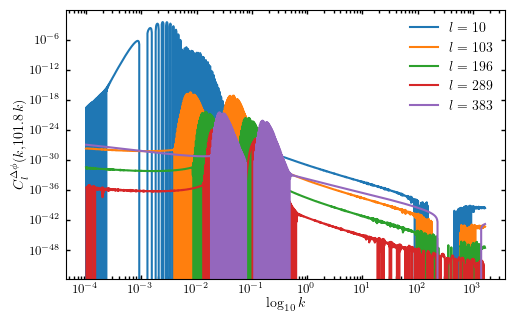

In [68]:
# Let us look into an offset diagonal
offset_idx = 100
offset_k = round((k_array[1]/k_array[0])*offset_idx,1)

for l_to_plot in np.linspace(10,lmax,5, dtype=int):
    plt.loglog(k_array[:-offset_idx], np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2, offset=offset_idx)[l_to_plot,:], label=r'$l={}$'.format(l_to_plot))
plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$C_l^{\Delta \phi}(k, $'+str(offset_k)+'$\,k)$')

plt.legend()

Wild oscillations ensue once the shift becomes larger than a few tens, so I don't expect any signal to come from regimes with a larger shift

# Testing FFTLog

/global/homes/a/ab2368/.conda/envs/varying_dndz/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


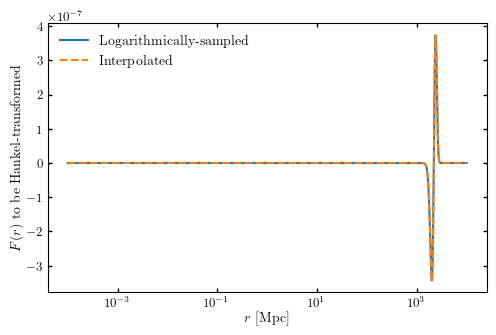

/global/homes/a/ab2368/.conda/envs/varying_dndz/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/tmp/ipykernel_195099/1740207689.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  p_lm_singlek[i], err[i] = quadrature(integrand, Planck18.comoving_distance(0.01).value,


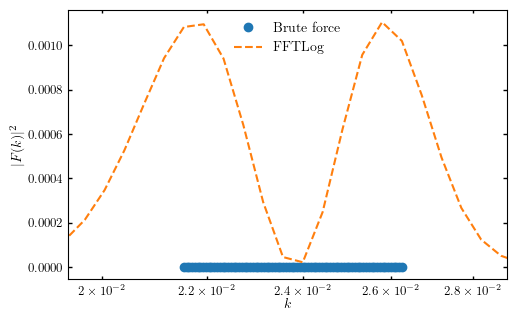

In [159]:
# Choose just one of the m's that we want to Hankel-transform. We will run our test on this one alone
test_idx = 50
# We will need the l corresponding to this m to compute the (l+0.5)th order Hankel transform
test_l, test_m = hp.Alm.getlm(lmax, test_idx) 

# Interpolate the function to be Hankel transformed so we can do it by brute-force
inter_func = interpolate.interp1d(r_array, delta_p_lm_of_r[test_idx,:], bounds_error=True)
plt.semilogx(r_array, delta_p_lm_of_r[test_idx,:], label='Logarithmically-sampled')
plt.semilogx(r_array, inter_func(r_array), ls='--', label='Interpolated')
plt.xlabel(r'$r$ [Mpc]')
plt.ylabel(r'$F(r)$ to be Hankel-transformed')
plt.legend()
plt.show()

# First, integrate using FFTLog
test_k_array, test_delta_p_lm_of_k = hankl.FFTLog(r_array, r_array*delta_p_lm_of_r[test_idx,:], q=0, 
                                                  mu=test_l+0.5, ext=2, lowring=True)
result_fftlog = test_delta_p_lm_of_k*np.conj(test_delta_p_lm_of_k)/test_k_array**2

# Compare to a brute-force numerical integration
def integrand(r, k, test_l):
    # The integrand of the Hankel transform we want
    return inter_func(r) * r * jv(test_l + 0.5, k*r)

# Use the FFTlog calculation to refine the domain overwhich we do brute force
log_kmin_bruteforce = np.log10(test_k_array[np.where(result_fftlog>0.001)[0][0]])
log_kmax_bruteforce = np.log10(test_k_array[np.where(result_fftlog>0.001)[0][-1]])

shortened_test_k_array = np.logspace(log_kmin_bruteforce, log_kmax_bruteforce, 80)
p_lm_singlek = np.zeros_like(shortened_test_k_array)
err = np.zeros_like(shortened_test_k_array)
for i, test_k in enumerate(shortened_test_k_array):
    # At a few values of k, get the Hankel transform by brute force
    p_lm_singlek[i], err[i] = quadrature(integrand, Planck18.comoving_distance(0.01).value, 
                                   Planck18.comoving_distance(10).value, args=(test_k, test_l),
                                         tol=1e-5,  maxiter=1000)

plt.semilogx(shortened_test_k_array, p_lm_singlek*np.conj(p_lm_singlek), ls='none', marker='o', label='Brute force')
plt.semilogx(test_k_array, result_fftlog, ls='--', label='FFTLog')
plt.xlabel(r'$k$')
plt.ylabel(r'$|F(k)|^2$')
plt.xlim([10**log_kmin_bruteforce*0.9, 10**log_kmax_bruteforce*1.1])
plt.legend()